In [1]:
import pandas as pd
import torch as th
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def augment(dataframe, threshold):

    df = pd.read_pickle(dataframe)
    esm_vectors = df["esm2"].values.tolist()
    esm_vectors = th.stack(esm_vectors)
    eye_matrix = th.eye(esm_vectors.shape[0])
    similarity_matrix = th.matmul(esm_vectors, esm_vectors.T)
    similarity_matrix = th.softmax(similarity_matrix, dim=1)
    similarity_matrix = similarity_matrix - eye_matrix

    augmented_annotations = list()
    
    for i, row in tqdm(enumerate(df.itertuples()), total=len(df)):
        most_similar = th.argmax(similarity_matrix[i, :]).item()
        if similarity_matrix[i, most_similar] > threshold:
            other_annots = df.iloc[most_similar].prop_annotations
            other_annots = set(other_annots)
            augmented_annots = set(row.prop_annotations) | other_annots
        else:
            augmented_annots = set(row.prop_annotations)

        augmented_annotations.append(list(augmented_annots))

    df["aug_prop_annotations"] = augmented_annotations
        
    return df

In [10]:
def get_similarity_matrix(df):
    esm_vectors = df["esm2"].values.tolist()
    esm_vectors = th.stack(esm_vectors)
    norms = th.norm(esm_vectors, p=2, dim=1, keepdim=True)
    esm_vectors = esm_vectors/norms
    similarity_matrix = th.matmul(esm_vectors, esm_vectors.T)
    mask = th.eye(similarity_matrix.size(0)).bool()
    similarity_matrix[mask] = float('-inf')

    similarity_matrix = th.sigmoid(similarity_matrix)
    mask = (similarity_matrix > 0.675).float()
    similarity_matrix = similarity_matrix * mask
    #similarity_matrix = th.softmax(similarity_matrix, dim=1)
    return similarity_matrix

In [30]:
def show_histogram(tensor):
    flat_tensor = tensor.flatten()
    threshold = -1  # This means we consider values within -0.05 to 0.05 as very close to 0

    # Create a mask
    mask = th.abs(flat_tensor) >  threshold

# Filter the tensor
    filtered_tensor = flat_tensor[mask].numpy()
    # Create the histogram
    plt.hist(filtered_tensor, bins=100)  # Adjust the number of bins as needed
    plt.title('Distribution of Tensor Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [5]:
df = pd.read_pickle("data-sim/mf/train_data.pkl")

In [11]:
sim_matrix = get_similarity_matrix(df)

In [12]:
sim_matrix.min()

tensor(0.)

In [13]:
sim_matrix.max()

tensor(0.7311)

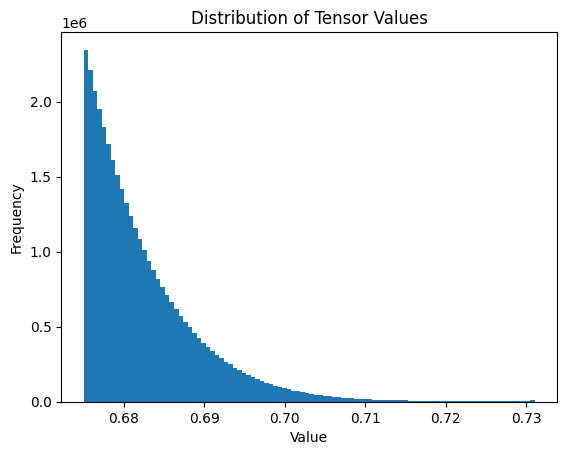

In [14]:
show_histogram(sim_matrix)

In [18]:
th.sum(sim_matrix[5, :])

tensor(2022.5564)

In [19]:
terms_df = pd.read_pickle("data-sim/mf/terms.pkl")
terms = terms_df['gos'].values.flatten()
terms_dict = {v: i for i, v in enumerate(terms)}

labels = th.zeros((len(df), len(terms_dict)), dtype=th.float32)

for i, row in enumerate(df.itertuples()):
    if not hasattr(row, 'prop_annotations'):
        continue
    for go_id in row.prop_annotations:
        if go_id in terms_dict:
            g_id = terms_dict[go_id]
            labels[i, g_id] = 1


In [20]:
labels.shape

torch.Size([39432, 7114])

In [21]:
sim_matrix.shape

torch.Size([39432, 39432])

In [22]:
per_class_annots = th.sum(labels, dim=0)

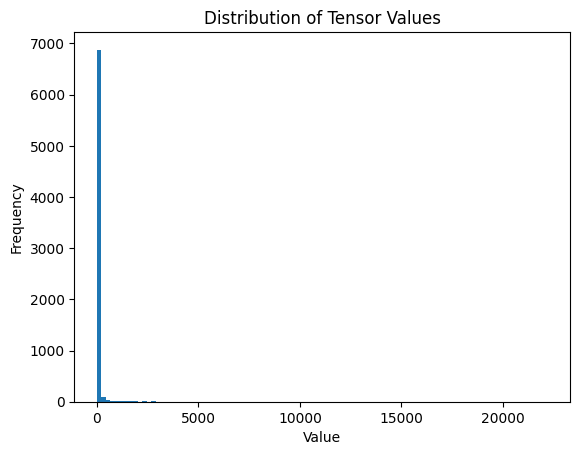

In [31]:
show_histogram(per_class_annots)

In [32]:
weighted_labels = th.zeros(labels.shape)
labels = labels.cuda()
pos_labels_den = (labels == 1).float().sum(dim = 0)
pos_labels_den = th.where(pos_labels_den == 0, th.ones_like(pos_labels_den), pos_labels_den)

for i, prot_annots in tqdm(enumerate(labels), total = len(labels)):
    prot_similarities = sim_matrix[i].unsqueeze(1).cuda()
    w_labels = prot_similarities * labels
    agg_w_labels = th.sum(w_labels, dim = 0) / pos_labels_den
    pos_mask = labels[i] == 1
    neg_mask = labels[i] != 1
    agg_w_labels = neg_mask * agg_w_labels + pos_mask 
    weighted_labels[i] = agg_w_labels

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.05 GiB (GPU 0; 11.90 GiB total capacity; 0 bytes already allocated; 432.12 MiB free; 0 bytes reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [35]:
weighted_labels

tensor([[0.6424, 0.0000, 0.6457,  ..., 1.0000, 0.6405, 1.0000],
        [0.6323, 0.0000, 0.6495,  ..., 0.6358, 1.0000, 0.6353],
        [0.6475, 0.0000, 0.6563,  ..., 0.6350, 0.6393, 0.6351],
        ...,
        [0.6272, 0.0000, 0.6350,  ..., 0.6454, 0.6397, 0.6431],
        [0.6220, 0.0000, 0.6158,  ..., 1.0000, 0.6271, 1.0000],
        [0.6422, 0.0000, 0.6468,  ..., 0.6422, 1.0000, 0.6424]])

In [36]:
per_class_w_annots = th.sum(weighted_labels, dim=0)

In [37]:
per_class_w_annots

tensor([25012.3047,     0.0000, 24950.5957,  ..., 29623.3242, 31431.5352,
        33167.7422])

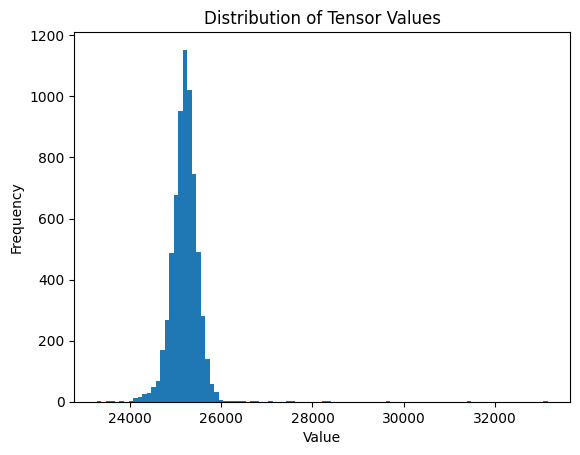

In [40]:
show_histogram(per_class_w_annots)